In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sounddevice as sd

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
#import mdct

import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import hankel
from scipy.linalg import hankel
from scipy.signal import lfilter


from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib.pyplot as plt
import numpy as np

import wave

> ## ESPRIT

In [9]:
def ESPRIT(x : np.ndarray, n : int, K : int):
    # input
        # x: input signal
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: order of signal

        # (n-K : noise space dimension)

    # output
        # delta: array of damping factors
        # f: array of frequencies

    N = len(x)          # signal's length
    l = N - n + 1       # number of columns of the Hankel matrix
                        # Not needed for the 'hankel' function but used in the formula of R_XX  

    X = hankel(x[:n], x[n-1:])      # Hankel matrix

    R_XX = 1/l * X @ X.conj().T             # correlation matrix
    U1, Lambda, U2 = np.linalg.svd(R_XX)
    W = U1[:n, :K]                          # signal space matrix
    
    W_down = W[:-1]
    W_up = W[1:]
    phi = (np.linalg.pinv(W_down)) @ W_up
    eigenvalues, eigenvectors = np.linalg.eig(phi)
    
    delta = np.log(np.abs(eigenvalues))         # damping factors
    f = (1/(2*np.pi)) * np.angle(eigenvalues)   # frequencies

    return delta, f


> ## Least Squares

In [46]:
def LeastSquares(x : np.ndarray, delta : np.ndarray, f : np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # f: array of frequencies

    # output
        # alpha: array of complex amplitudes
        # a: array of real amplitudes
        # phi: array of initial phases

    N = len(x)                  # signal's length
    t = np.arange(N)            # array of discrete times
    s = delta + 2j*np.pi*f      # log of the pole
    VN = np.exp(np.outer(t,s))  # Vandermonde matrix of dimension N
    
    alpha = np.linalg.pinv(VN)@x
    a = abs(alpha)
    phi = np.angle(alpha)
    
    return alpha, a, phi

> ## Energy

In [55]:
def Energy(x: np.ndarray, delta: np.ndarray, a: np.ndarray):
    # input
        # x: input signal
        # delta: array of damping factors
        # a: array of real amplitudes

    # output
        # EdB: array of energies

    
    N = len(x)              # signal's length
    times = np.arange(N)    # array of discrete times

    K = len(delta)          # number of sinusoids
    E = np.zeros(K)

    for k in range(K):      # calculating the energy of each sinusoid
        e_k = 0
        for t in times:
            e_k += np.exp(2*delta[k]*t)     # the contribution of delta
        E[k] = a[k]**2 * e_k                # the energy of the kth sinusoid

    Emax = max(E)
    EdB = 10*np.log(E/Emax)     # Energy in dB

    return EdB


> ## Signal Synthesis

> Synthesis Function(s)

In [56]:
def Synthesis(N: int, delta: np.ndarray, f: np.ndarray, a: np.ndarray, phi : np.ndarray, noisy = False):
    # N: length of the signal (discrete)
    # delta: array of damping factors
    # f: array of normalized frequencies
    # a: array of real amplitudes
    # phi: array of initial phases
    # noisy: set to True if a noisy signal is desired 

    t = range(N)                    #time range
    logz = delta + 1j*2*np.pi*f     #log of poles
    alpha = a*np.exp(1j*phi)        #complex amplitudes
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz, t)), axis=0)  #noisless signal (ESM)
    if noisy == False:
        s = x
    else:   #synthesizing noise
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-noisy/20) #This is from TP HR. Isn't noisy equal to 1 in this case? Maybe this was originally meant to be a general formula without an if statement?
        s = x+b     #noisy signal
    return s

In [57]:
# TO BE VERIFIED
# I think it is better to use the Synthesis function from the TP
# since it can synthesise noisy signals as well
# The commented lines are used for plotting the signal and the spectrum.
# In my opinion they should not be in this function.
def synthesis(time, delta, f, a, phi):
    K = len(delta)
    #N = len(time)
    signal = np.zeros(1, N)
    #Te = time[1] - time[0]
    #fe = 1/Te
    #Nfft = 2**nextpow2(N)
    #freq = np.arange(-fe/2, fe/2, fe/Nfft)
    for i in range(K):
        signal_i = a[i]*np.multiply(np.exp(delta[i]*time), np.cos(2*np.pi*time*f[i] + phi[i]))  #PS: This function uses the real ESM not the complex one.
        signal += signal_i

    return signal


> Synthesised Signal

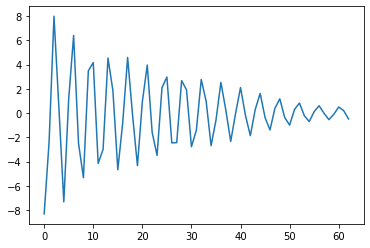

In [58]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = Synthesis(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x0))

> Verification

In [59]:
delta_an, f_an = ESPRIT(x_synth, 32, 2)

alpha_an, a_an, phi_an = LeastSquares(x_synth, delta_an, f_an)

EdB_an = Energy(x_synth, delta_an, a_an)

print(delta_an, f_an, alpha_an, a_an, phi_an, EdB_an)


[-5.0000000e-02 -4.4408921e-16] [0.26587302 0.25      ] [8.77582562+4.79425539j 0.0707372 +0.99749499j] [10.  1.] [0.5 1.5] [  0.         -28.12365928]


> ## Adaptative Algorithm

In [60]:
def adaptative(x_full : np.ndarray, window_length : float, hop_size : float, sampling_rate : int, n : int, K : int):
    # input
        # x_full: the full-length input signal
        # window_length: the window size (in seconds)
        # hop_size: the hop size (in seconds)
        # n: number of lines in the Hankel matrix S
        # and signal space basis W
        # K: the number of sinusoids

    N_full = len(x_full)                    # the length of the signal (in samples)
    N = int(window_length*sampling_rate)    # window size (in samples)
    h = int(hop_size*sampling_rate)         # hope size (in samples)
    I = int((N_full-N)/h)

    delta, f, alpha, a, phi, EdB = np.zeros(I)

    for i in range(I):

        x_i = x_full[i:i+h]     # ith truncated signal

        delta[i], f[i] = ESPRIT(x_i, n, K)
        alpha[i], a[i], phi[i] = LeastSquares(x_i, delta[i], f[i])
        EdB[i] = Energy(x[i], delta[i], a[i])

    return delta, f, alpha, a, phi, EdB

> ## To do: 
(Hopefully by Tuesday 14:00)

- synthesise a signal with variant frequencies and test the adaptative algorithm
- add more visualisations

- pretreat the signal

◮ Colored noise
> smoothing the periodogram (with a moving average filter)
> whitening the filter with an FIR (which normalises the smoothed periodogram)

◮ Unknown number of sinusoids
> Use the energy function to decide which sinusoids to keep (the others are considered noise and discarded)
> ESTER ? apply it to the whole signal or to the chunks in the adaptive iteration


◮ High number of sinusoids (calculation time)
> Bank filters with downsampling ? details